array([[ 1.15260754e+01,  4.59519449e+00,  4.67555701e+00,
         4.59757868e+00],
       [ 1.15151941e+01,  5.27746459e+00,  4.61904208e+00,
         4.59232035e+00],
       [ 1.15164272e+01,  5.60121658e+00,  4.71946482e+00,
         4.60950257e+00],
       [ 1.14987383e+01,  5.92205403e+00,  4.85883241e+00,
         4.60062090e+00],
       [ 1.15420355e+01,  6.21242666e+00,  5.04501669e+00,
         4.64828451e+00],
       [ 1.14764219e+01,  6.36715492e+00,  5.26171340e+00,
         4.62509388e+00],
       [ 1.15335402e+01,  6.63940709e+00,  5.49522891e+00,
         4.63746379e+00],
       [ 1.15014801e+01,  6.83470794e+00,  5.72663014e+00,
         4.64215675e+00],
       [ 1.14978571e+01,  7.05129435e+00,  5.91338861e+00,
         4.68439263e+00],
       [ 1.14998268e+01,  7.30793210e+00,  6.12511228e+00,
         4.74175622e+00],
       [ 1.14795885e+01,  7.46693932e+00,  6.34368918e+00,
         4.72963650e+00],
       [ 1.14905427e+01,  7.73060965e+00,  6.58695346e+00,
      

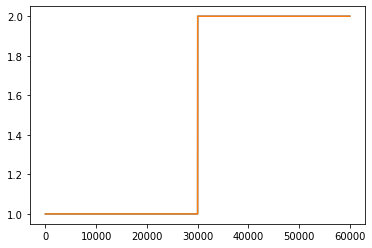

In [1]:
import numpy as np
import pickle
import torch
import scipy
import argparse
import sys
from arma import ode_system, solve_magi
from arma import matrix
import time
import pickle
import matplotlib.pyplot as plt
import scipy.special as fun
from multiprocessing import Pool


N = 100000.
param=[0.1, 0.1, 0.05]
days = 60
def gen_data(beta_series=None, random=True, lambda0=0.05, days=days, obs_per_day=1, state0=[100000., 100., 100., 100.], 
             lb= 0.5, ub=1.5, linspace=1000, noise=0.03,seed=5):
    """
    random: If True, simulate a change point arrival as poisson process with rate lambda0. 
            If False, input a series of beta with dimension days * obs_per_day * linspace
    lambda0: rate of Poisson arrival
    obs_per_day: measurement per day
    state0: population of S, E, I and D state
    linspace: discretization of 
    params: parameter: [beta, ve, vi, pd]
    noise: noise level of the observation
    param: ve, vi, pd = [0.1, 0.1, 0.05]
    """
    # number of change points
    global N, param
    state_ls = np.ones((days * obs_per_day * linspace, 4))
    step_size = 1. / (linspace * obs_per_day)
    if beta_series is None:
        if seed is not None:
            np.random.seed(seed)
        n_cp = np.random.poisson(lambda0 * days)
        beta_series = np.zeros(days * obs_per_day * linspace)
        
        if seed is not None:
            np.random.seed(seed)
        time = np.sort(np.random.uniform(1, days * obs_per_day * linspace, n_cp).astype(int))
        if seed is not None:
            np.random.seed(seed)
        val = np.random.uniform(lb, ub, n_cp+1)
        for i in range(time[0]):
            beta_series[i] = val[0]
        for idx in range(0, n_cp-1):
            beta_series[time[idx]:time[idx+1]] = val[idx+1]
        for i in range(time[-1], len(beta_series)):
            beta_series[time[-1]:] = val[-1]
    state_ls = np.zeros((days * linspace * obs_per_day, 4))    
    for i in range(4):
        state_ls[0][i] = state0[i]
    ve, vi, pd = param[0], param[1], param[2]
    plt.plot(beta_series)
    for i in range(1, linspace * days * obs_per_day):
        state_ls[i][0] = state_ls[i - 1][0] - step_size * beta_series[i-1] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * beta_series[i-1] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * ve * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * ve * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * vi
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * vi * pd
    states = state_ls[::linspace]
    if seed is not None:
        np.random.seed(seed)
    states2 = states * np.random.normal(1, noise, states.shape)
    return np.log(states2), np.log(states), beta_series#, n_cp, time/(linspace*obs_per_day), beta_series  

x = np.linspace(0, 4 * np.pi, 60000)
# beta_series0 = 0.5 * np.sin(x) + 1.5
beta_series = np.concatenate((1.0 * np.ones(30000), 2.0 * np.ones(30000)))
observations, true_data, true_beta = gen_data(beta_series=beta_series) # beta_series=beta_series
plt.plot(beta_series)
observations

In [2]:
# Derivatves of X according to the ODE structure
def fOde(theta, x):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[0] * np.exp(logI) / N  # (1)
    logEdt = theta[0] * np.exp(logS + logI - logE) / N - theta[1]  # (2)
    logIdt = np.exp(logE - logI) * theta[1] - theta[2]  # (3)
    logDdt = np.exp(logI - logD) * 0.25 * theta[3] * theta[2]  # (4)
    return np.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


# Derivatives of X
def fOdeDx(theta, x):
    """
    returns derivation of x given theta
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    resultDx = np.zeros(shape=[np.shape(x)[0], np.shape(x)[1], np.shape(x)[1]])
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程关于第i个状态求导
    # (1) / dI
    resultDx[:, 2, 0] = -theta[0] * np.exp(logI) / N
    # (1) / dS, (1) /dE, (1) / dD = 0
    # (2) / dS
    resultDx[:, 0, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dE
    resultDx[:, 1, 1] = -theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dI
    resultDx[:, 2, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dD = 0
    # (3) / dS = 0
    # (3) / dE
    resultDx[:, 1, 2] = np.exp(logE - logI) * theta[1]
    # (3) / dI
    resultDx[:, 2, 2] = -np.exp(logE - logI) * theta[1]
    # (3) / dD = 0, (4) / dS, dE = 0
    # (4) / dI
    resultDx[:, 2, 3] = np.exp(logI - logD) * 0.25 * theta[3] * theta[2]
    # (4) / dD
    resultDx[:, 3, 3] = -np.exp(logI - logD) * 0.25 * theta[3] * theta[2]
    return resultDx


def fOdeDtheta(theta, x):
    """
    returns derivation of theta given x
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    global N
    resultDtheta = np.zeros(shape=[np.shape(x)[0], np.shape(theta)[0], np.shape(x)[1]])
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程对theta_i求导
    # (1) / dRe
    resultDtheta[:, 0, 0] = -np.exp(logI) / N
    # (2) / d theta[0]
    resultDtheta[:, 0, 1] = np.exp(logS + logI - logE) / N
    # (2) / theta[1]
    resultDtheta[:, 1, 1] = -1.
    # (3) / dtheta[1]
    resultDtheta[:, 1, 2] = np.exp(logE - logI)
    # (3) / dtheta[2]
    resultDtheta[:, 2, 2] = -1.
    # (4) / theta[2]
    resultDtheta[:, 2, 3] = np.exp(logI - logD) * 0.25 * theta[3] 
    # (4) / theta[3]
    resultDtheta[:, 3, 3] = np.exp(logI - logD) * 0.25 * theta[2]
    return resultDtheta



def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])





days = 60
discretization = 1
obs_per_day = 1
theta_lowerbound=np.array([0., 0., 0., 0.])
theta_upperbound=np.array([np.inf, 1., 1., 1.])
param_names = ['re', 've', 'vi', 'pd']
use_trajectory='inferred'
learning_rate=np.array([1e-4, 1e-3, 1e-5])
n_iter = [15001, 80000, 15000, 60000]
yobs = observations
start_time = time.time()
nobs, p_dim = yobs.shape[0], yobs.shape[1]
n_points = days * discretization
theta_dim = theta_lowerbound.shape[0]
d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])


# First stage: use MAGI package to optimize theta as constant #####################


result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=n_iter[0],
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=40,
    useFrequencyBasedPrior=True,
    useBand=False,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(n_iter[0] * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
print(inferred_theta)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
for each_gpcov in result['result_solved'].covAllDimensions:
        each_pycov = dict(
            Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
            Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
            mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
        )
        CovAllDimensionsPyList.append(each_pycov)

[1.62593533 0.07772592 0.05658281 0.34418717]


In [72]:
CovAllDimensionsPyList_dict = {}
min_len = 10
max_len = 60
for SeriesLength in range(min_len, max_len+1):
    CovAllDimensionsPyList = []
    for each_gpcov in result['result_solved'].covAllDimensions:
        Cinv = torch.inverse(torch.from_numpy(matrix(each_gpcov.C)[:SeriesLength, :SeriesLength])).double()
        print(Cinv.shape)
        mphi = torch.from_numpy((matrix(each_gpcov.mphi).dot(matrix(each_gpcov.C)))[:SeriesLength, :SeriesLength].dot(Cinv)).double()
        Kinv = torch.from_numpy(np.linalg.inv(matrix(each_gpcov.Kphi)[:SeriesLength, :SeriesLength])).double()
        each_pycov = dict(
            Cinv=Cinv,
            mphi=mphi,
            Kinv=Kinv,
        )
        CovAllDimensionsPyList.append(each_pycov)
        
    CovAllDimensionsPyList_dict[SeriesLength] = CovAllDimensionsPyList

torch.Size([10, 10])
torch.Size([10, 10])
torch.Size([10, 10])
torch.Size([10, 10])
torch.Size([11, 11])
torch.Size([11, 11])
torch.Size([11, 11])
torch.Size([11, 11])
torch.Size([12, 12])
torch.Size([12, 12])
torch.Size([12, 12])
torch.Size([12, 12])
torch.Size([13, 13])
torch.Size([13, 13])
torch.Size([13, 13])
torch.Size([13, 13])
torch.Size([14, 14])
torch.Size([14, 14])
torch.Size([14, 14])
torch.Size([14, 14])
torch.Size([15, 15])
torch.Size([15, 15])
torch.Size([15, 15])
torch.Size([15, 15])
torch.Size([16, 16])
torch.Size([16, 16])
torch.Size([16, 16])
torch.Size([16, 16])
torch.Size([17, 17])
torch.Size([17, 17])
torch.Size([17, 17])
torch.Size([17, 17])
torch.Size([18, 18])
torch.Size([18, 18])
torch.Size([18, 18])
torch.Size([18, 18])
torch.Size([19, 19])
torch.Size([19, 19])
torch.Size([19, 19])
torch.Size([19, 19])
torch.Size([20, 20])
torch.Size([20, 20])
torch.Size([20, 20])
torch.Size([20, 20])
torch.Size([21, 21])
torch.Size([21, 21])
torch.Size([21, 21])
torch.Size([2

In [70]:
CovAllDimensionsPyList_dict[60][0]['Cinv'].shape

torch.Size([59, 59])

In [54]:
def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[:, 0] * torch.exp(logI) / N  # (1)
    logEdt = theta[:, 0] * torch.exp(logS + logI - logE) / N - constant_param_ls[0]  # (2)
    logIdt = torch.exp(logE - logI) * constant_param_ls[0] - constant_param_ls[1]  # (3)
    # reparametrize on pd
    logDdt = torch.exp(logI - logD) * 0.25 * constant_param_ls[1] * constant_param_ls[2]  # (4)
    return torch.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day, positive_param=True):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)


is_time_varying=[True, False, False, False]
TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1

if use_trajectory == 'observation':
    pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
elif use_trajectory == 'inferred':
    pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
else:
    raise ValueError
tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == 0:
        param_name = param_names[thetaEachDim]
        locals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
        time_constant_param_ls.append(eval(param_name))

ydata = torch.from_numpy(yFull).double()
priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=10000, gamma=0.5)
cur_loss = 1e12
for epoch in range(n_iter[1]):
    pointwise_optimizer.zero_grad()
    # compute loss function
    llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
                                        ydata, CovAllDimensionsPyList, fOdeTorch,
                                        priorTemperature, obs_per_day)
    new_loss = -llik
    if epoch % 200 == 0:
        print(epoch, new_loss.item())
        diff = new_loss.item() - cur_loss
        if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
            break
        cur_loss = new_loss.item()
    new_loss.backward()
    pointwise_optimizer.step()
    pointwise_lr_scheduler.step()

0 -287.1507040423686


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


200 -293.68922500459104
400 -299.9154751427509
600 -306.66351126997455
800 -313.7193063553382
1000 -320.98403269025533
1200 -328.4129471669149
1400 -335.99139617664713
1600 -343.70486671339404
1800 -351.5668607863398
2000 -359.59781871948235
2200 -367.81847031449007
2400 -376.2570042045775
2600 -384.9438888971258
2800 -393.9144512273311
3000 -403.19815908495815
3200 -412.82881349343745
3400 -422.83090859259477
3600 -433.21273109142965
3800 -444.0000720576338
4000 -455.1539664682357
4200 -466.6456777059225
4400 -478.41788968051503
4600 -490.40250387025503
4800 -502.5341281229745
5000 -514.7575380844938
5200 -527.0206324503657
5400 -539.2708473039645
5600 -551.4424755555943
5800 -563.4701737786866
6000 -575.2916448923919
6200 -586.8561210930391
6400 -598.1196024174653
6600 -609.0397834506243
6800 -619.6404823866037
7000 -629.87087978582
7200 -639.7202541215879
7400 -649.1108972013645
7600 -657.8800571970623
7800 -665.7857200571447
8000 -672.5444132293227
8200 -677.9197562649542
8400 -681

In [74]:
#### piecewise constant

def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[:, 0] * torch.exp(logI) / N  # (1)
    logEdt = theta[:, 0] * torch.exp(logS + logI - logE) / N - constant_param_ls[0]  # (2)
    logIdt = torch.exp(logE - logI) * constant_param_ls[0] - constant_param_ls[1]  # (3)
    # reparametrize on pd
    logDdt = torch.exp(logI - logD) * 0.25 * constant_param_ls[1] * constant_param_ls[2]  # (4)
    return torch.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day, positive_param=True):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)


def construct(vals, occurence_times, days = 60):
    ls = []
    for idx in range(occurence_times[0]):
        ls.append(vals[0])
    for idx in range(occurence_times[1]):
        ls.append(vals[1])
    return torch.cat(ls, axis=0).reshape(-1, vals.shape[1])
    
def new_likelihood(xlatent, vals, occurence_times, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, days):
    new_theta = construct(vals, occurence_times, days)
    return pointwisethetasigmallikTorch(xlatent, new_theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day)

def max_llik(cur_days):
    is_time_varying=[True, False, False, False]
    TV_theta_mean = np.zeros(int(sum(is_time_varying)))
    tv_index = 0
    for thetaEachDim in range(theta_dim):
        if is_time_varying[thetaEachDim] == True:
            TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
            tv_index += 1
    time_constant_param_ls = []
    for thetaEachDim in range(theta_dim):
        if is_time_varying[thetaEachDim] == 0:
            param_name = param_names[thetaEachDim]
            locals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
            time_constant_param_ls.append(eval(param_name))
    
    ###################
    total_iter = cur_days - 1
    # vals_ls = np.zeros((total_iter, len(vals)))
    # occurence_times_ls = np.zeros((total_iter, len(vals)))
    constant_ls = []
    lik_ls = np.zeros(total_iter)
    occurence_times = np.array([0, cur_days])
    for EachIter in range(total_iter):
        print(EachIter)
        occurence_times[0] += 1
        occurence_times[1] -= 1
        vals_tmp = torch.tensor(np.array([[1.5], [1.5]]), requires_grad=True)
        truncate_pointwise_xlatent_torch_tmp = pointwise_xlatent_torch.detach().clone()[:cur_days]
        truncate_pointwise_xlatent_torch_tmp.requires_grad = True
        sigma_torch_tmp = sigma_torch.detach().clone()
        sigma_torch_tmp.requires_grad = True
        pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp, vals_tmp, sigma_torch_tmp] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
        pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
        cur_loss_tmp = np.inf
        for epoch in range(100000):
            pointwise_optimizer.zero_grad()
            # compute loss function

            llik = new_likelihood(truncate_pointwise_xlatent_torch_tmp, vals_tmp, occurence_times, time_constant_param_ls, sigma_torch_tmp,
                                        ydata[:cur_days], CovAllDimensionsPyList_dict[cur_days], fOdeTorch,
                                        priorTemperature, cur_days)
            new_loss = -llik
            if epoch % 200 == 0:
                print(epoch, new_loss.item())
                diff = new_loss.item() - cur_loss_tmp
                if torch.isnan(new_loss) == False and diff > -1. and diff < 1.:
                    break
                cur_loss_tmp = new_loss.item()
            new_loss.backward()
            pointwise_optimizer.step()
            pointwise_lr_scheduler.step()
        lik_ls[EachIter] = llik.item()
        
    return lik_ls
    ###################

    # Initialize occurence times, sum(cur_occurence_times) = len(theta)
    
#     time_constant_param_ls = []
#     for thetaEachDim in range(theta_dim):
#         if is_time_varying[thetaEachDim] == 0:
#             param_name = param_names[thetaEachDim]
#             locals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
#             time_constant_param_ls.append(eval(param_name))

#     ydata = torch.from_numpy(yFull[:cur_days]).double()
#     priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
#     truncate_pointwise_xlatent_torch_tmp = pointwise_xlatent_torch.detach().clone()[:cur_days]
#     truncate_pointwise_xlatent_torch_tmp.requires_grad = True
#     sigma_torch_tmp = sigma_torch.detach().clone()
#     sigma_torch_tmp.requires_grad = True
#     pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp, vals_tmp, sigma_torch_tmp] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
#     pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
#     cur_loss_tmp = np.inf
#     for epoch in range(100000):
#         pointwise_optimizer.zero_grad()
#         # compute loss function
        
#         llik = new_likelihood(truncate_pointwise_xlatent_torch_tmp, vals_tmp, occurence_times, time_constant_param_ls, sigma_torch_tmp,
#                                     ydata, CovAllDimensionsPyList, fOdeTorch,
#                                     priorTemperature)
#         new_loss = -llik
#         if epoch % 200 == 0:
#             print(epoch, new_loss.item())
#             diff = new_loss.item() - cur_loss_tmp
#             if torch.isnan(new_loss) == False and diff > -1. and diff < 1.:
#                 break
#             cur_loss_tmp = new_loss.item()
#         new_loss.backward()
#         pointwise_optimizer.step()
#         pointwise_lr_scheduler.step()
        
# max_llik(60)
res_ls = {}
for each in range(10, 60):
    res_ls[each] = max_llik(each)

0
0 27851.469021022553
200 16865.728257135546
400 10706.766600020554
600 6763.565318842581
800 4217.940035926586
1000 2591.77071975574
1200 1573.1787975185077
1400 952.0379617930125
1600 585.6491153568345
1800 377.5855518638971
2000 263.8443410908087
2200 203.33101307103072
2400 170.92740786963458
2600 152.2416013437466
2800 139.65031944485128
3000 129.4661056022141
3200 120.0799969192438
3400 110.87235716389831
3600 101.6445421997642
3800 92.36655906926109
4000 83.06579364617119
4200 73.7900771026172
4400 64.5943347236646
4600 55.5338440720009
4800 46.66218252589994
5000 38.028853921162685
5200 33.72948407720004
5400 29.332547712326257
5600 24.86084106236887
5800 20.33908257050349
6000 15.793079875277176
6200 11.249146314310554
6400 6.7334980830851485
6600 2.2716627934904245
6800 -2.11207151639978
7000 -6.395140118420688
7200 -10.55711802401865
7400 -14.58002054420512
7600 -18.448436601320413
7800 -22.149753314873685
8000 -25.674033216170756
8200 -29.01401044250875
8400 -32.1649435947

In [85]:
import pickle

with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(res_ls, f)
        
# with open('saved_dictionary.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)

llik = []

for key in res_ls.keys():
    print(np.max(res_ls[key])-res_ls[key][0])
    llik.append(np.max(res_ls[key])-res_ls[key][0])

0.0
0.0
0.0
0.0
0.46576140309015557
0.0
0.0
0.9446254804461915
0.6481762297783007
0.06526511726320905
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
17.405153848906195
34.88287155167029
50.2195807309966
64.67901544304004
81.01908748824701
92.8207506694389
106.40069124250817
120.87273527114587
129.66811039542046
136.01810876385082
142.7134119941823
147.93787785568875
154.60215626672522
161.1360332789244
166.61167610687906
174.46305993886105
180.9406443049366
186.9192170695532
192.89139188564428
201.4987479526277
213.2612051368787
226.4647247722819
240.98792660209023


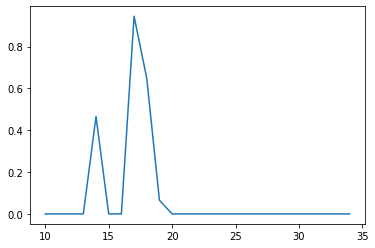

In [94]:
plt.plot(np.arange(10, 60, 1)[:25], np.array(llik)[:25])
# plt.scatter(np.array([30]), np.array([0]))

In [89]:
res_ls

{10: array([51.46928209, 51.15650144, 50.16060613, 50.32576682, 50.21735274,
        50.12748163, 50.97752327, 50.81194609, 50.8297356 ]),
 11: array([59.03792142, 58.19139456, 58.50561639, 57.87528748, 57.94312255,
        57.88373909, 57.81878525, 57.75180081, 58.70962152, 58.66761654]),
 12: array([67.73535798, 67.28892186, 66.78170512, 66.22734524, 66.43671473,
        66.4160005 , 66.3519627 , 66.3085477 , 66.25629839, 66.25895639,
        66.31155557]),
 13: array([75.30008552, 74.83107755, 74.64767608, 74.12911659, 73.4445126 ,
        73.58627916, 73.59290179, 73.5638139 , 73.5405194 , 73.51043618,
        73.52214877, 74.55770494]),
 14: array([83.56361662, 84.02937802, 83.2320588 , 82.77762478, 83.1033992 ,
        82.25827234, 82.36739698, 82.39334718, 82.38199233, 82.37526378,
        82.36640554, 82.39800689, 83.4411529 ]),
 15: array([91.18202726, 91.17888688, 90.53099247, 90.02363172, 89.30313972,
        89.53180342, 89.61127064, 89.60744523, 89.58812965, 89.57909032,
 

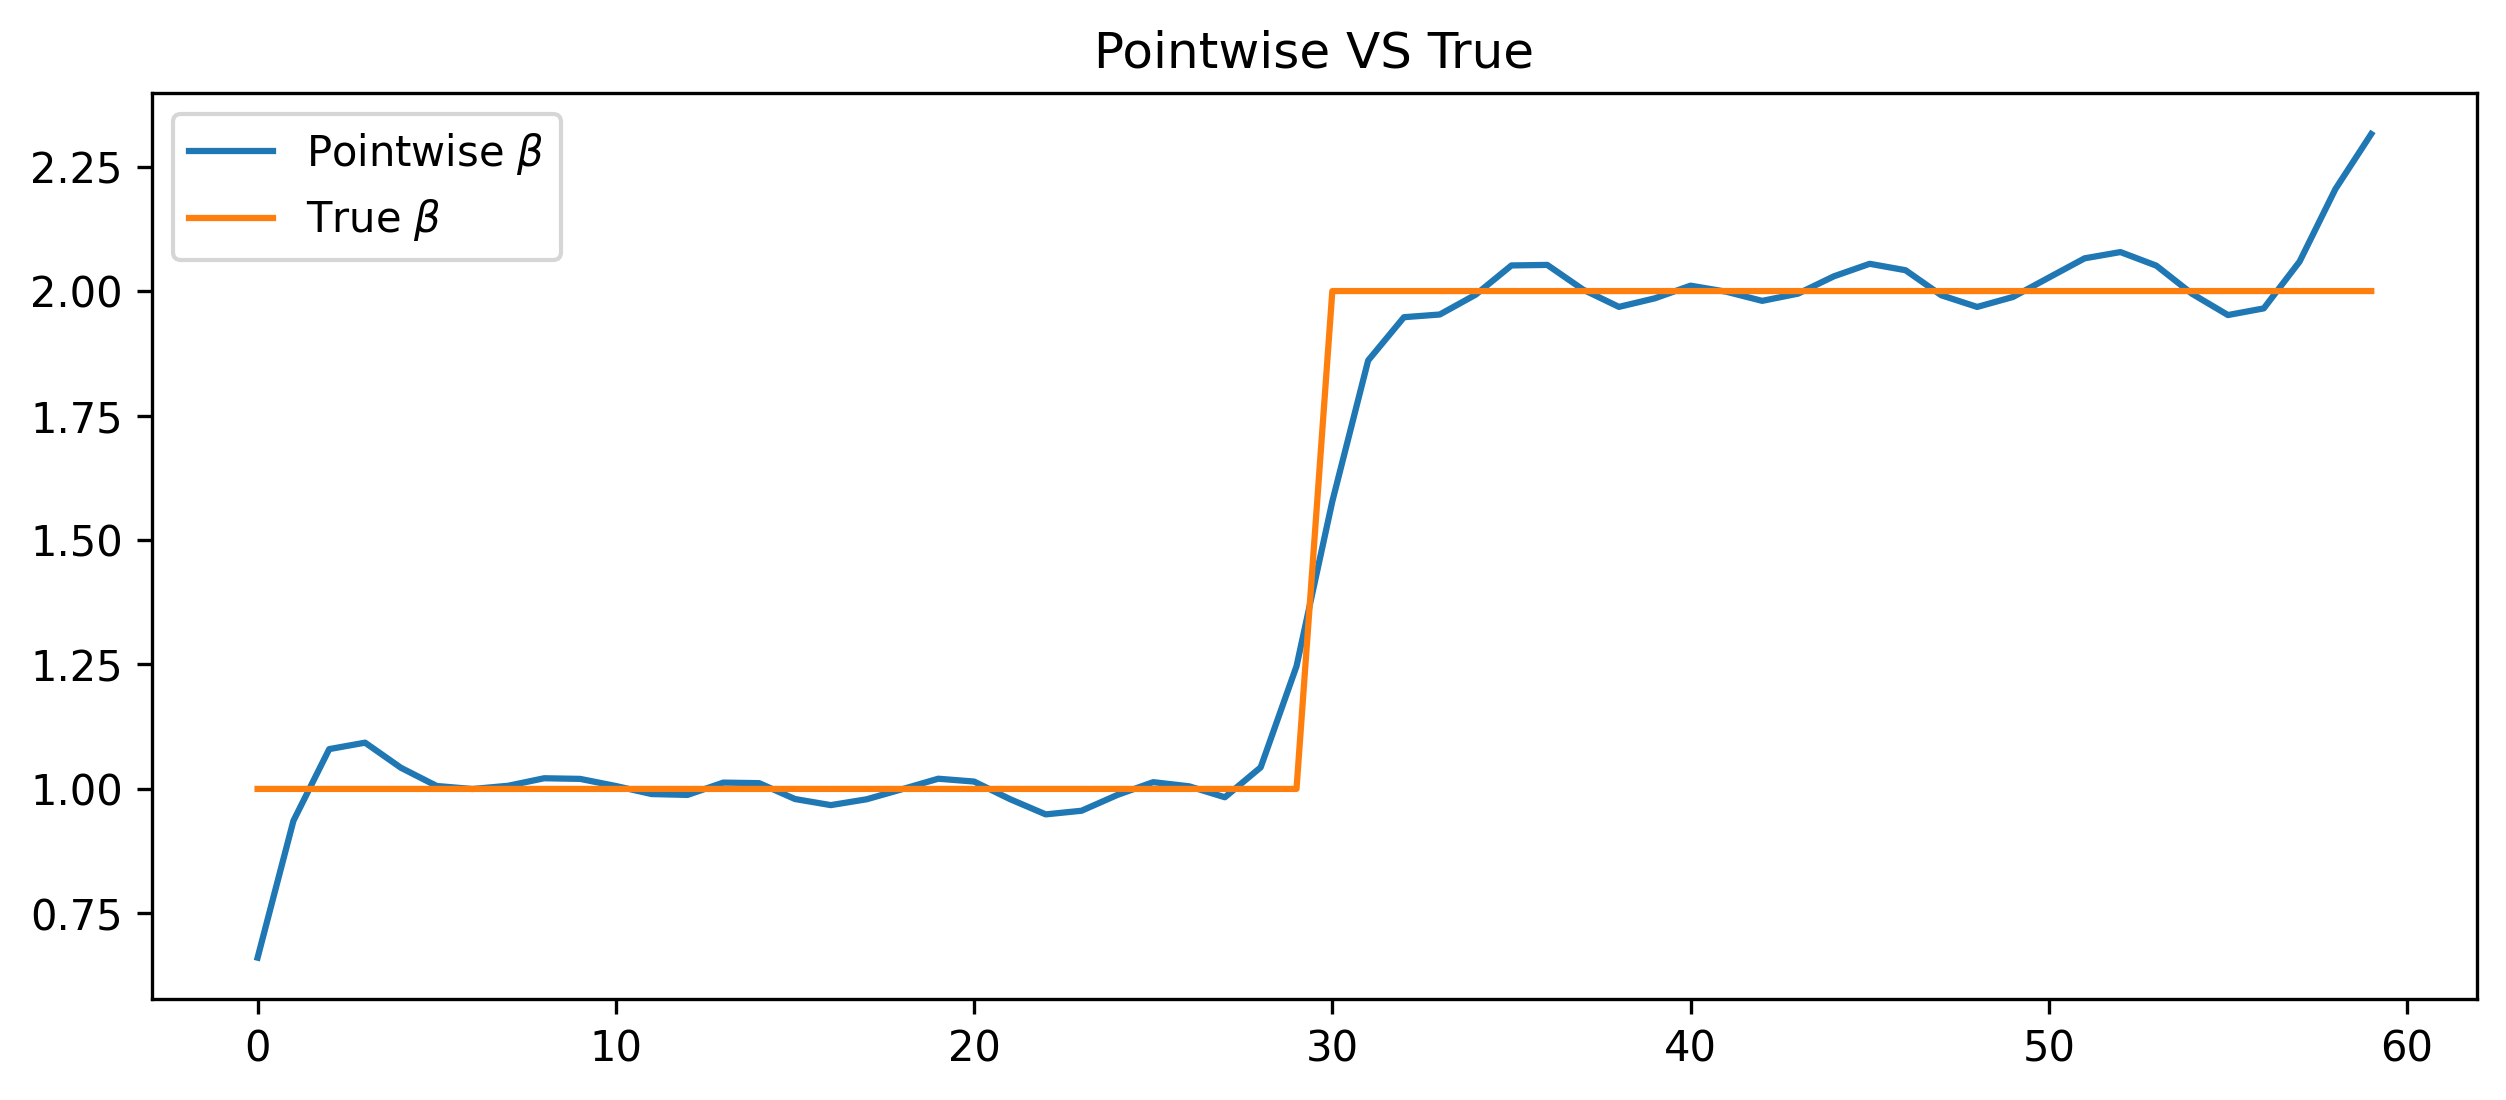

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

figsize(10, 4)

pointwise_xlatent_torch1 = torch.tensor(xInitExogenous, dtype=torch.double)
pointwise_xlatent_torch2 = torch.tensor(inferred_trajectory.transpose(), dtype=torch.double)
pointwise_xlatent_torch3 = torch.tensor(true_data, dtype=torch.double)
plt.plot(pointwise_theta_torch.detach().numpy()[:, 0], label=r'Pointwise $\beta$')
plt.plot(true_beta[::1000], label=r'True $\beta$')
plt.title('Pointwise VS True')
plt.legend()
plt.show()
true_theta_torch = torch.tensor(true_beta.reshape(-1, 1))

In [9]:
def construct(vals, occurence_times, days = 60):
    ls = []
    for idx in range(occurence_times[0]):
        ls.append(vals[0])
    for idx in range(occurence_times[1]):
        ls.append(vals[1])
    return torch.cat(ls, axis=0).reshape(-1, vals.shape[1])
    
def new_likelihood(xlatent, vals, occurence_times, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature):
    new_theta = construct(vals, occurence_times)
    return pointwisethetasigmallikTorch(xlatent, new_theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day)



vals = torch.tensor(np.array([[1.5], [1.5]]), requires_grad=True)

# Initialize occurence times, sum(cur_occurence_times) = len(theta)
occurence_times = np.array([0, 60])
total_iter = 58
# vals_ls = np.zeros((total_iter, len(vals)))
# occurence_times_ls = np.zeros((total_iter, len(vals)))
constant_ls = []
lik_ls = np.zeros(total_iter)
for EachIter in range(total_iter):
    print(EachIter)
    occurence_times[0] += 1
    occurence_times[1] -= 1
    vals_tmp = vals.detach().clone()
    vals_tmp.requires_grad = True
    pointwise_xlatent_torch_tmp = pointwise_xlatent_torch.detach().clone()
    pointwise_xlatent_torch_tmp.requires_grad = True
    sigma_torch_tmp = sigma_torch.detach().clone()
    sigma_torch_tmp.requires_grad = True
    pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch_tmp, vals_tmp, sigma_torch_tmp] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
    pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
    cur_loss_tmp = np.inf
    for epoch in range(100000):
        pointwise_optimizer.zero_grad()
        # compute loss function
        
        llik = new_likelihood(pointwise_xlatent_torch_tmp, vals_tmp, occurence_times, time_constant_param_ls, sigma_torch_tmp,
                                    ydata, CovAllDimensionsPyList, fOdeTorch,
                                    priorTemperature)
        new_loss = -llik
        if epoch % 200 == 0:
            print(epoch, new_loss.item())
            diff = new_loss.item() - cur_loss_tmp
            if torch.isnan(new_loss) == False and diff > -1. and diff < 1.:
                break
            cur_loss_tmp = new_loss.item()
        new_loss.backward()
        pointwise_optimizer.step()
        pointwise_lr_scheduler.step()
    lik_ls[EachIter] = llik.item()

0
0 68130.24743233073
200 50789.76376212983
400 40918.758454786905
600 33225.84867712423
800 26824.456815135545
1000 21521.003264795025
1200 17201.489371011256
1400 13745.395616346499
1600 11022.840711939687
1800 8903.831272546031
2000 7267.202219664157
2200 6006.713178757318
2400 5033.835789727829
2600 4277.782739322853
2800 3683.771793560539
3000 3210.459964851001
3200 2827.198635486696
3400 2511.4971804007873
3600 2246.8977842841723
3800 2021.3220493563954
4000 1825.8542411165995
4200 1653.8753310091329
4400 1500.4486681205744
4600 1361.884582588634
4800 1235.4217407041874
5000 1118.9970923334008
5200 1063.2145519479511
5400 1007.7408082011902
5600 952.7123256291096
5800 898.2600486436679
6000 844.5077668403915
6200 791.5766728516377
6400 739.5897713233896
6600 688.6752777747338
6800 638.9679103881172
7000 590.6075801592619
7200 543.7375625726962
7400 498.49787075813197
7600 455.02029923860755
7800 413.4178885666489
8000 373.7843224769092
8200 336.18182183821716
8400 300.63971889121

Text(0.5, 0, 'k')

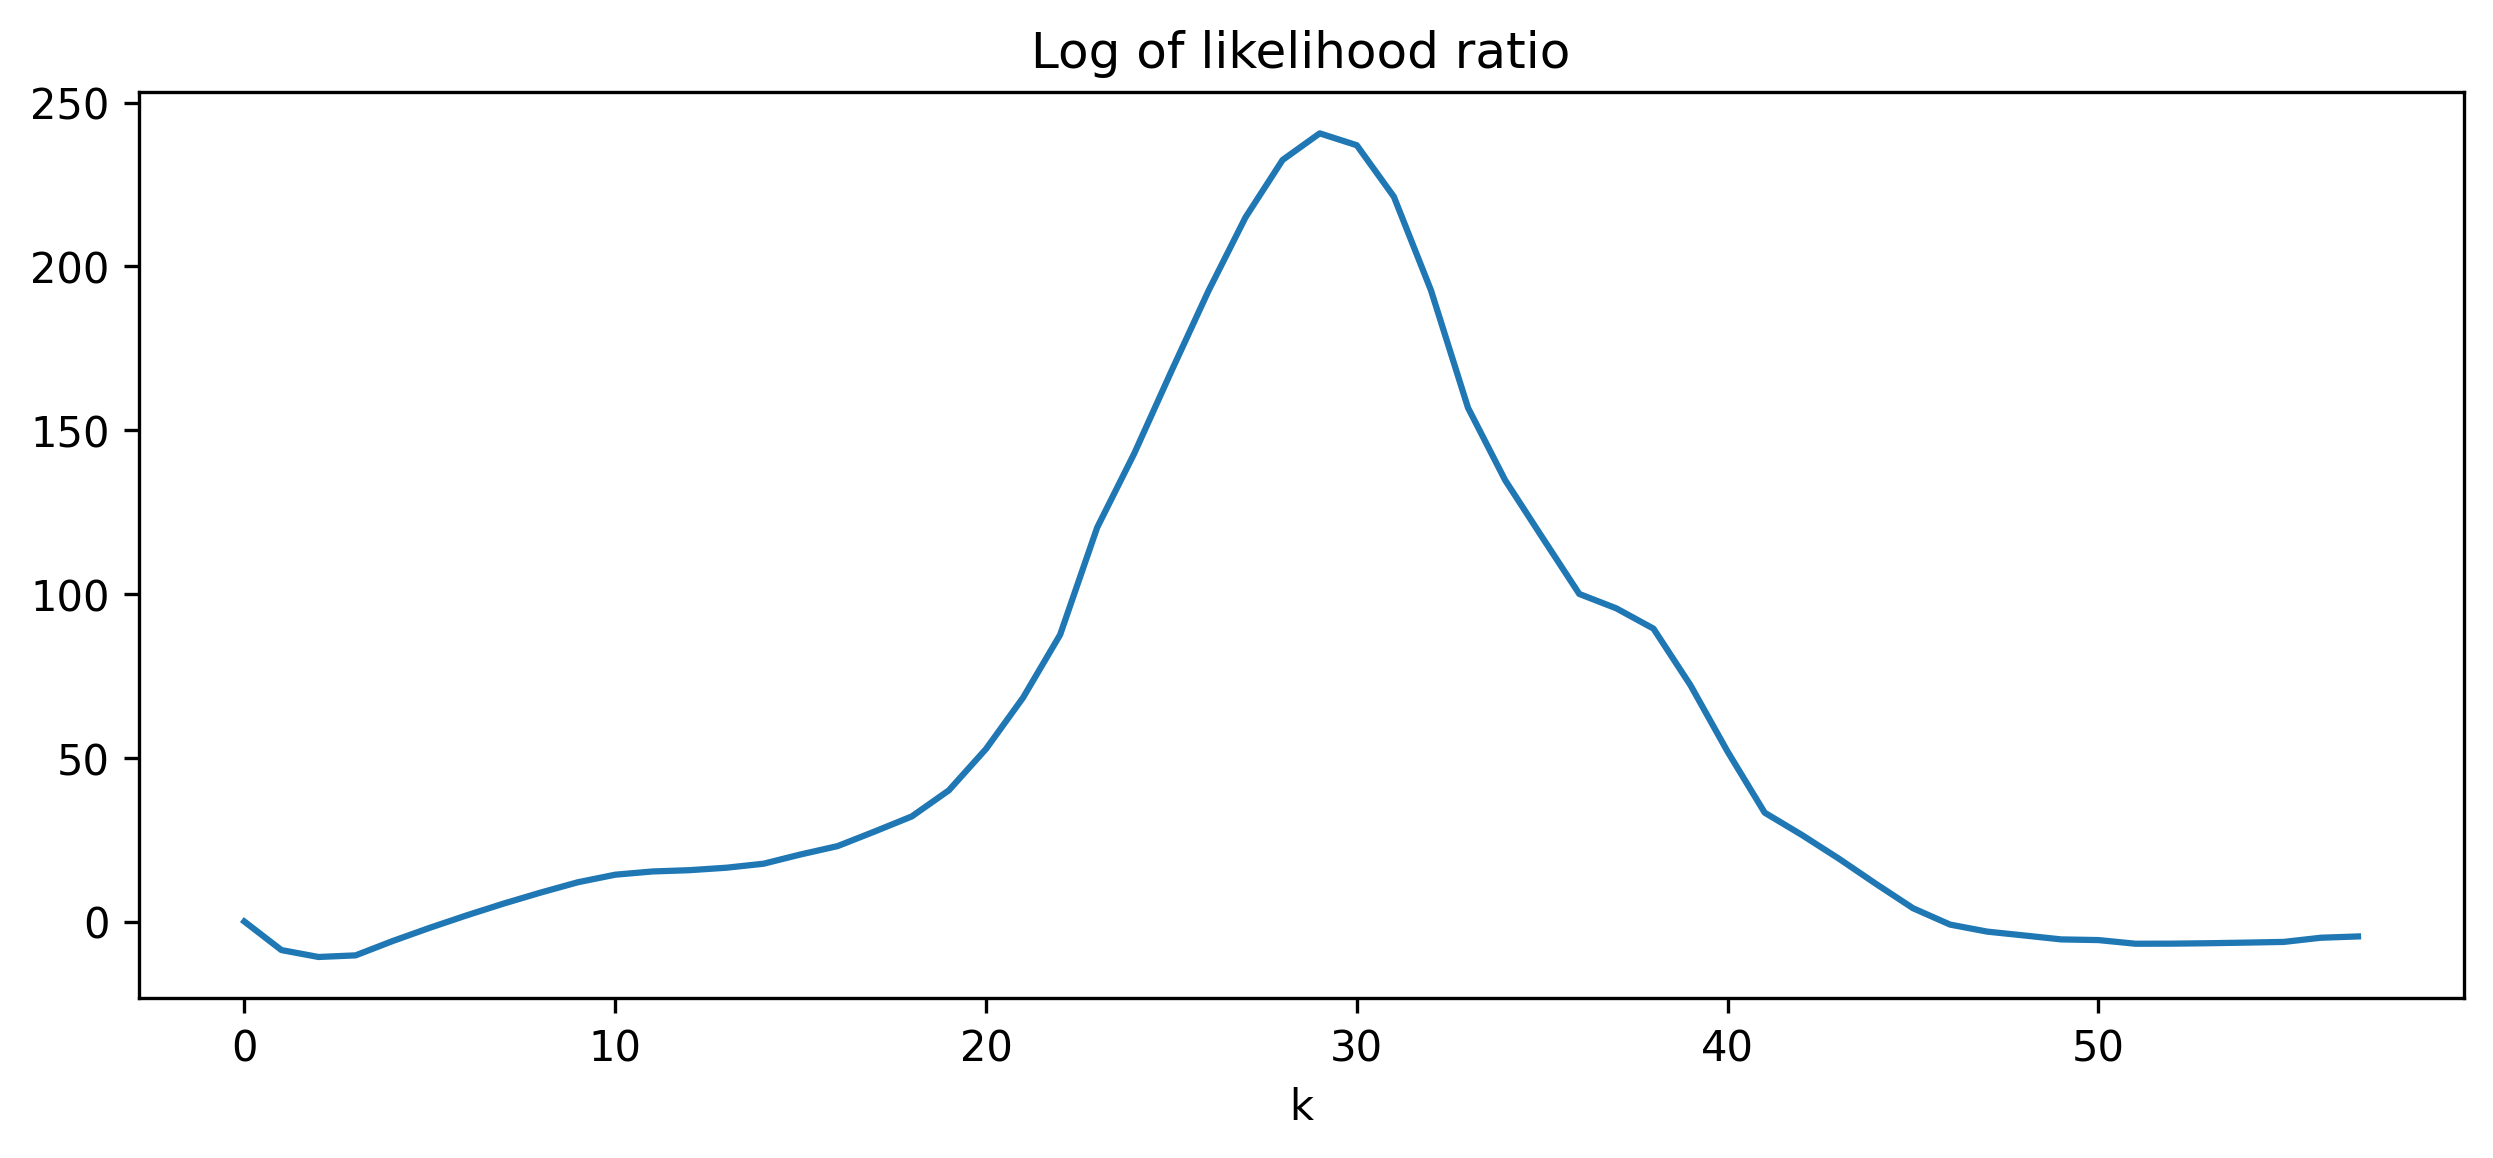

In [13]:
plt.plot(lik_ls - lik_ls[0])
plt.title('Log of likelihood ratio')
plt.xlabel('k')

In [30]:
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

figsize(10, 4)
plt.subplots_adjust(top=1,bottom=0,left=0,right=1, wspace =0, hspace =0)
ax1 = plt.subplot(1, 2, 1) # 两行一列，位置是1的子图

def construct(vals, occurence_times):
    ls = []
    for idx in range(len(vals)):
        if occurence_times[idx] != 0:
            for i in range(occurence_times[idx]):
                ls.append(vals[idx])
    return torch.cat(ls, axis=0).reshape(-1, vals.shape[1])


for i in range(57):
    print(i)
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(construct(torch.tensor(vals_ls[i]).reshape(-1, 1), occurence_times_ls[i].astype(int)).numpy().reshape(-1, 1))
    plt.plot(beta_series[::1000])
    ax1.set_title(str(i+1) + 'th Iteration')
    ax2 = plt.subplot(1, 2, 2)
    plt.plot(-lik_ls)
    plt.scatter(np.array([i]), -np.array([lik_ls[i]]), c='r')
    ax2.set_title('Likelihood: '+ str(-lik_ls[i]))
    plt.savefig('new-SEIRD-plots/plot-'+str(i)+'.png', bbox_inches='tight')
    plt.clf()

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


<Figure size 3000x1200 with 0 Axes>

0


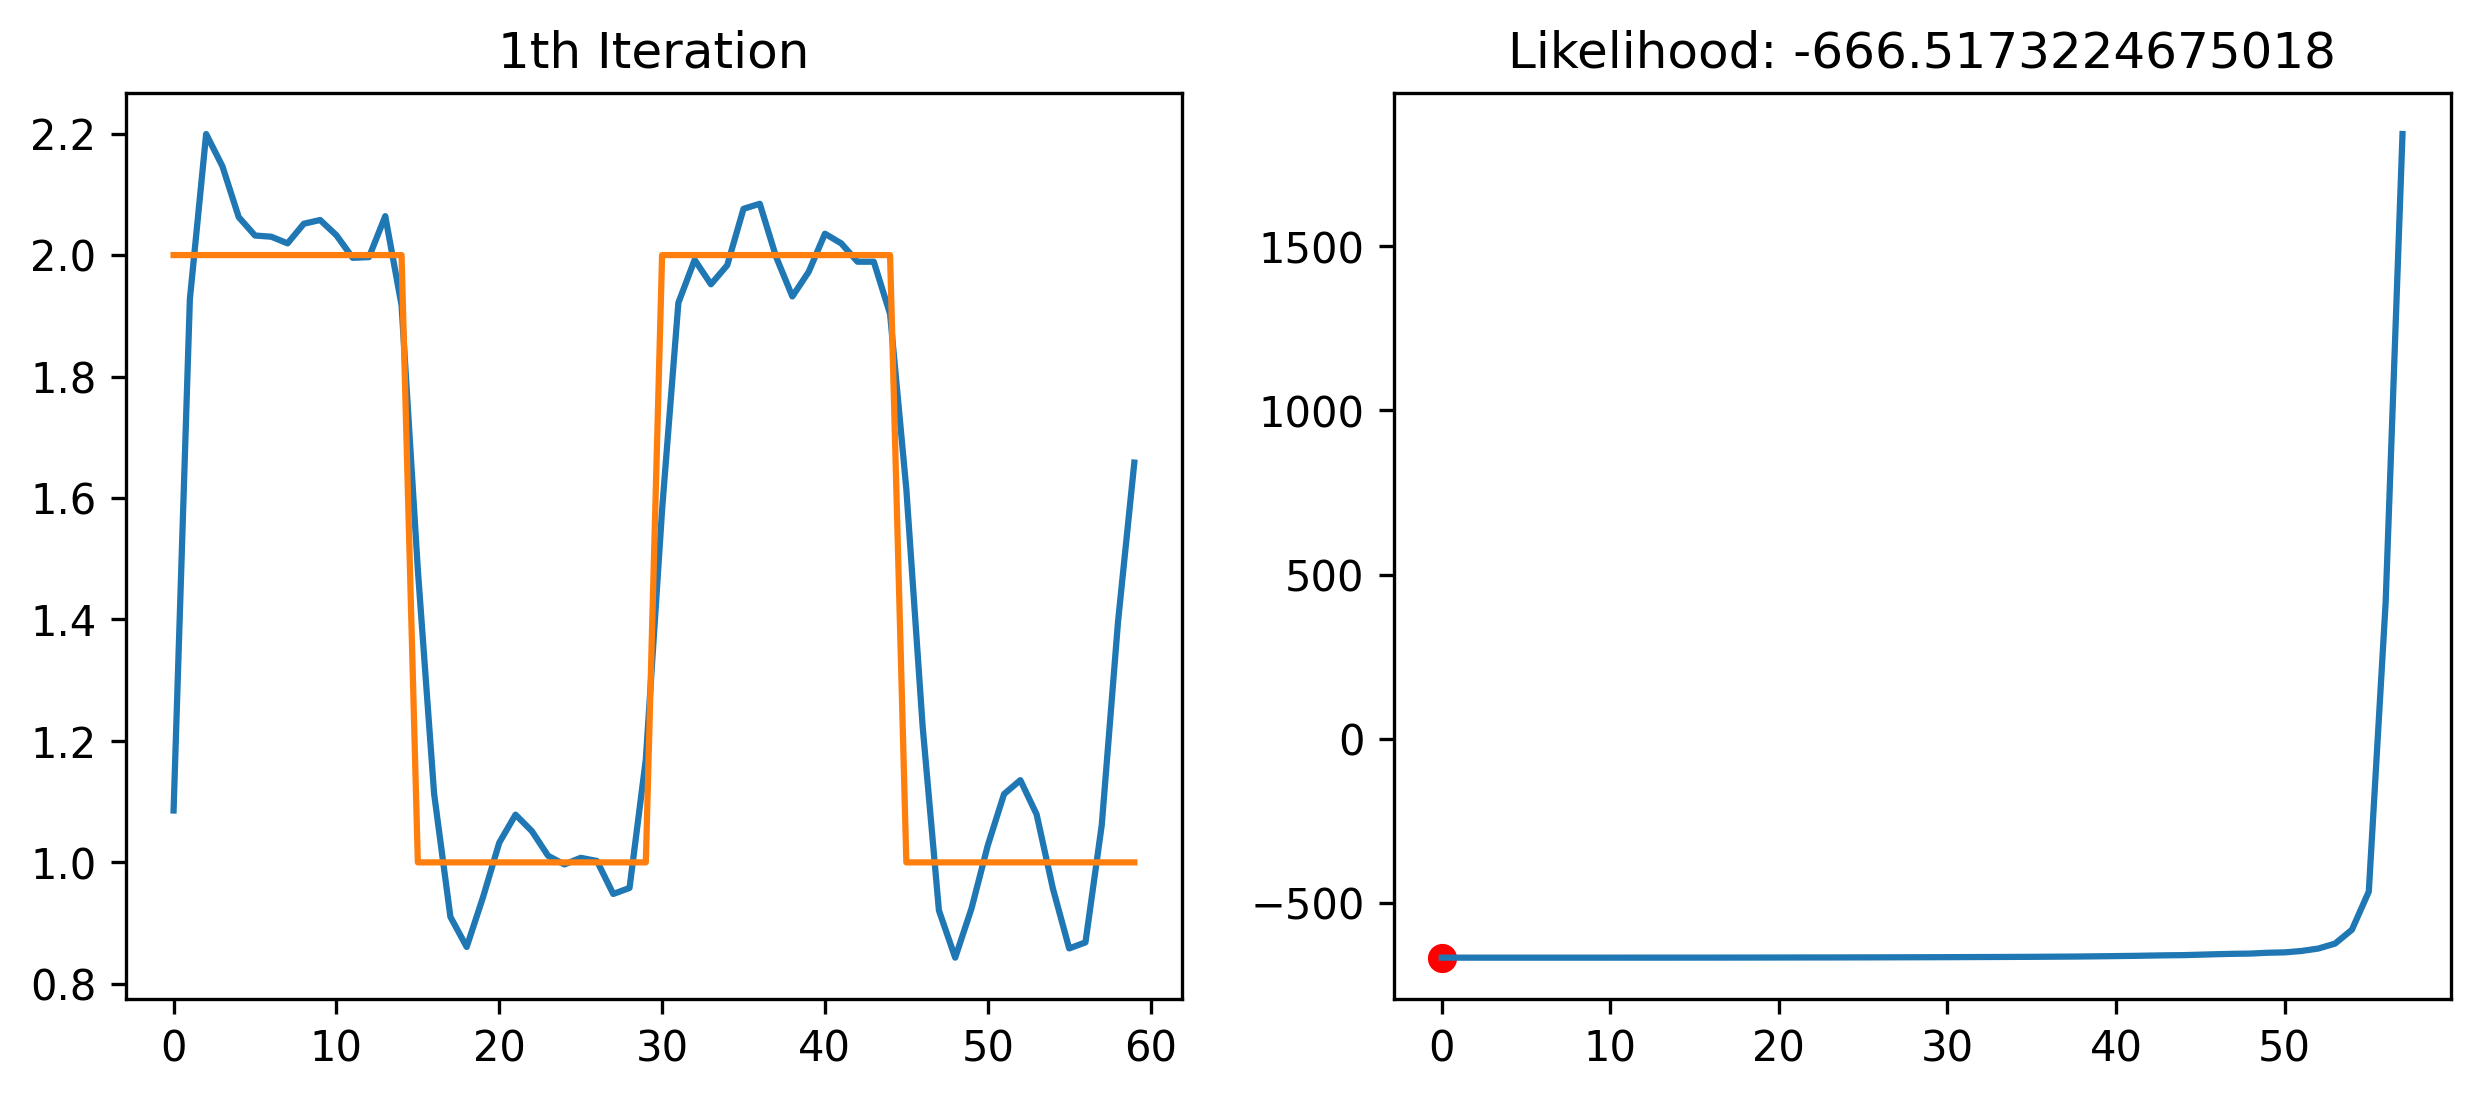

In [28]:
for i in range(1):
    print(i)
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(construct(torch.tensor(vals_ls[i]).reshape(-1, 1), occurence_times_ls[i].astype(int)).numpy().reshape(-1, 1))
    plt.plot(beta_series[::1000])
    ax1.set_title(str(i+1) + 'th Iteration')
    ax2 = plt.subplot(1, 2, 2)
    plt.plot(lik_ls)
    plt.scatter(np.array([i]), np.array([lik_ls[i]]), c='r')
    ax2.set_title('Likelihood: '+ str(lik_ls[i]))
    plt.show()

In [37]:
from scipy.stats import poisson

# Define event
A = np.zeros(yFull.shape[0])
A[0] = 1
# Prior probability
def pi(A, lambda0 = 0.05):
    return poisson.ppf(np.sum(A), lambda0)
# Define theta
theta_cur = torch.ones(yFull.shape[0]) * inferred_theta[0]
theta_cur.requires_grad = True
x_cur = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
sigma2_0 = 0.01
def log_pdf(x, var):
    return -torch.log(torch.sqrt(var)) - 0.5 * torch.log(2 * np.pi) - 0.5 * torch.square(x)/var
def BM_likelihood(A, xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day, theta_min=0.5, theta_max=2.0, sigma2_0=sigma2_0):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    prior = torch.zeros(0)
    for idx in range(A.shape[0]-1):
        if A[idx] == 0:
            prior += log_pdf(xlatent[idx+1]- xlatent[idx], sigma2_0/obs_per_day)
        else:
            prior += -torch.log(theta_max-theta_min)
    return torch.sum(res)+ prior

ydata = torch.from_numpy(yFull).double()
priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=10000, gamma=0.5)
cur_loss = 1e12
for epoch in range(n_iter[1]):
    pointwise_optimizer.zero_grad()
    # compute loss function
    llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
                                        ydata, CovAllDimensionsPyList, fOdeTorch,
                                        priorTemperature, obs_per_day)
    new_loss = -llik
    if epoch % 200 == 0:
        print(epoch, new_loss.item())
        diff = new_loss.item() - cur_loss
        if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
            break
        cur_loss = new_loss.item()
    new_loss.backward()
    pointwise_optimizer.step()
    pointwise_lr_scheduler.step()

0 14849.721627215033
200 11592.066995348368
400 10465.099882337923
600 9623.471405003816
800 8881.006236933947
1000 8206.38929436431
1200 7593.055881004269
1400 7035.642922759887
1600 6529.047008121434
1800 6068.421798529144
2000 5649.186014568857
2200 5267.04412556285
2400 4918.018951527256
2600 4598.488547314887
2800 4305.216645592877
3000 4035.3669608772693
3200 3786.4970144457075
3400 3556.53367681132
3600 3343.7363706135166
3800 3146.653967988302
4000 2964.0798084057615
4200 2795.007801917766
4400 2638.591733687068
4600 2494.1093406841774
4800 2360.932119956879
5000 2238.5010155794193
5200 2126.3072925425645
5400 2023.8773788550423
5600 1930.7604534826082
5800 1846.5179756085442
6000 1770.714860172725
6200 1702.9127862022217
6400 1642.6623901474957
6600 1589.504150915326
6800 1542.961563833956
7000 1502.5428435702308
7200 1467.741526830952
7400 1438.039389155142
7600 1412.9112466703064
7800 1391.8317873214223
8000 1374.2840498755565
8200 1359.770420351956
8400 1347.8178641385596
8

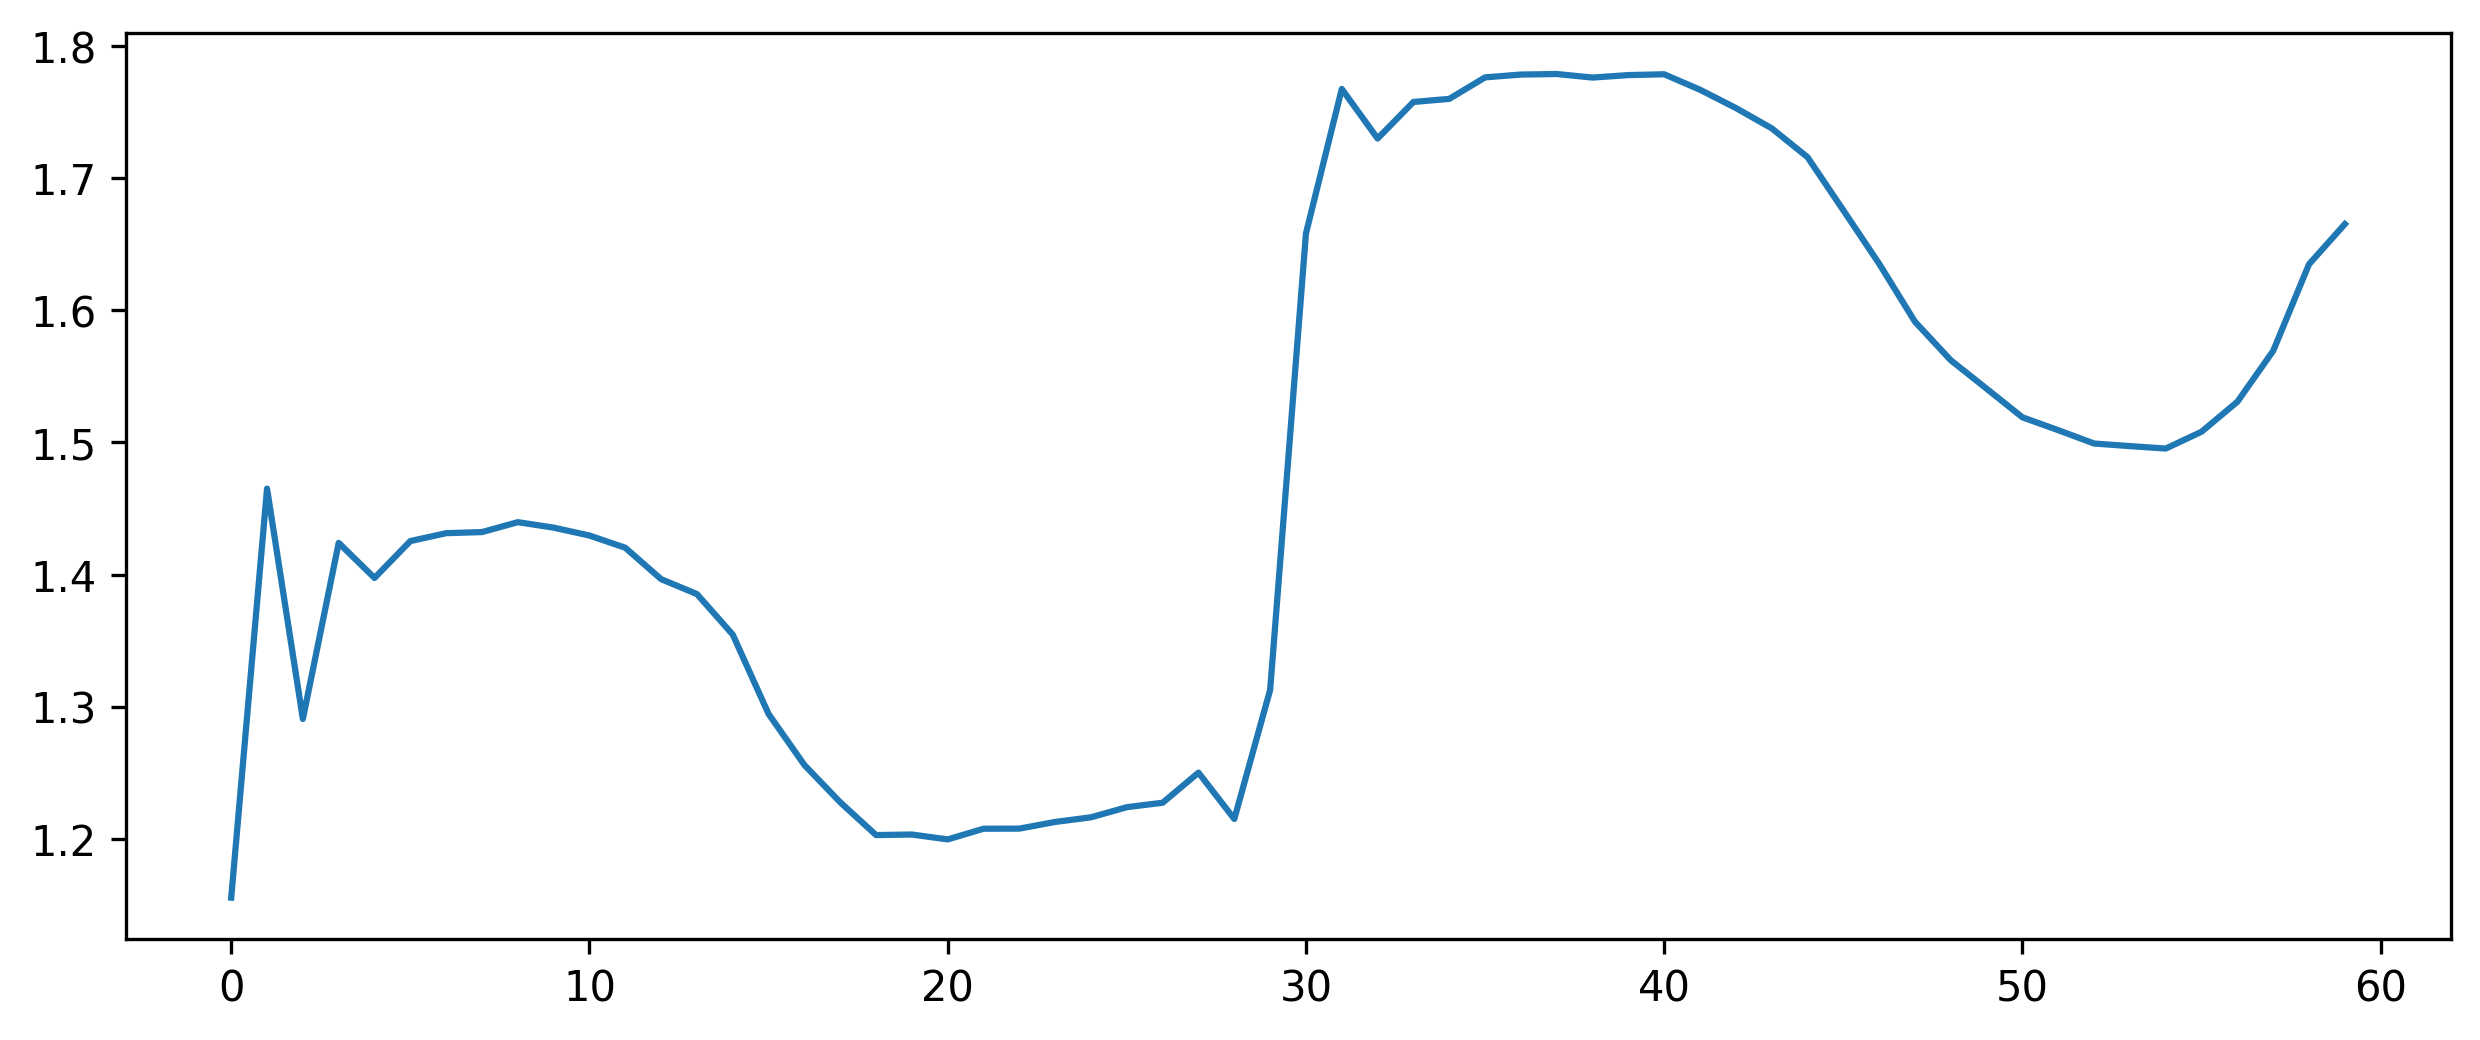

In [39]:
plt.plot(pointwise_theta_torch[:, 0].detach().numpy())

In [38]:
pointwise_theta_torch

tensor([[1.1557],
        [1.4651],
        [1.2909],
        [1.4240],
        [1.3975],
        [1.4254],
        [1.4314],
        [1.4322],
        [1.4397],
        [1.4356],
        [1.4296],
        [1.4204],
        [1.3966],
        [1.3854],
        [1.3547],
        [1.2946],
        [1.2560],
        [1.2278],
        [1.2030],
        [1.2035],
        [1.1998],
        [1.2078],
        [1.2079],
        [1.2130],
        [1.2165],
        [1.2241],
        [1.2275],
        [1.2503],
        [1.2152],
        [1.3128],
        [1.6581],
        [1.7674],
        [1.7299],
        [1.7576],
        [1.7599],
        [1.7762],
        [1.7783],
        [1.7787],
        [1.7761],
        [1.7779],
        [1.7785],
        [1.7668],
        [1.7530],
        [1.7377],
        [1.7159],
        [1.6757],
        [1.6352],
        [1.5914],
        [1.5622],
        [1.5407],
        [1.5191],
        [1.5093],
        [1.4992],
        [1.4973],
        [1.4954],
        [1